In [1]:
from uf3.jax.jax_splines import *
import jax.numpy as jnp
from jax.lax import dynamic_slice
import numpy as np
import ndsplines

from jax import vmap

import uf3.jax.potentials as pot
from uf3.jax.jax_splines import ndSpline_unsafe

from functools import partial

import matplotlib.pyplot as plt

from jax.config import config
config.update("jax_enable_x64", True)


<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
knots = [0, 0.5, 1.0, 1.5, 1.83333333, 2.16666667, 2.5, 2.83333333, 3.16666667, 3.5, 3.83333333, 4.16666667, 4.5, 4.83333333, 5.16666667, 5.5, 6.5, 7.5, 8.5]

coefficients = [ 1.25129255e+01,  5.93366978e+00,  2.64404190e+00,  3.89362649e-01, -1.80794686e-01, -2.84676830e-01, -2.67508086e-01, \
                -9.45645302e-02, 1.47269014e-02, -6.01878769e-03, -8.12415903e-03, 8.67558130e-03, -4.74148052e-03, -7.13338724e-04,  0.00000000e+00]

In [3]:
ks = [np.asarray(knots)]
cs = np.asarray(coefficients)
deg = np.asarray([3])

spline = ndsplines.NDSpline(ks, cs, deg, False, False)

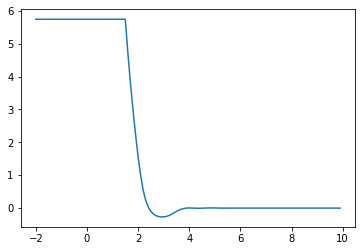

In [4]:
xpoints = np.arange(-2,10,0.1)

plt.plot(xpoints, spline(xpoints))
plt.show()

In [5]:
s = ndSpline_unsafe(ks, tuple(deg))

In [11]:
1.0 + jnp.asarray([[5]])

DeviceArray([[6.]], dtype=float64, weak_type=True)

In [6]:
s([2.5], coefficients=cs)

Traced<ShapedArray(float64[15])>with<DynamicJaxprTrace(level=0/1)>


DeviceArray(-0.10308215, dtype=float64)

In [15]:
test = np.asarray([[2.5,2.5],[4.5,3.5]])
test.shape

(2, 2)

In [32]:
def fn(dr, coefficients=None):
    spline = partial(s, coefficients=coefficients)
    f = lambda x: vmap(spline)(x[:,None])
    return vmap(f)(dr)

In [34]:
fn(test, coefficients=cs)

DeviceArray([[-0.10308215, -0.10308215],
             [-0.00497331, -0.10517322]], dtype=float64)

In [23]:
plt.plot(xpoints, vmap(s)(xpoints[:,None], coefficients=cs))
plt.show()

AssertionError: 

In [5]:
jax_spline = vmap(partial(deBoor_basis_unsafe,3, jnp.asarray(knots)))
coe = jnp.asarray(cs)
def f(x):
    i, res = jax_spline(x)
    r = np.zeros_like(x)
    for ix in range(len(x)):
        id = i[ix]
        if id >= 0 and id+4 <= len(coe):
            r[ix] = jnp.sum(coe[id:id+4] * res[ix,:])
        else:
            r[ix] = 0
    return r



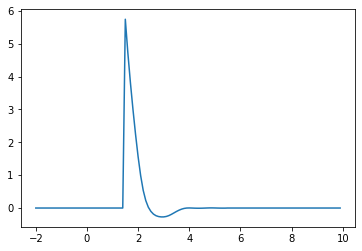

In [6]:
plt.plot(xpoints, f(xpoints))
plt.show()

# Simple potentials

In [9]:
uf2 = partial(pot.uf2_interaction, coe, jnp.asarray(knots), 8.0)

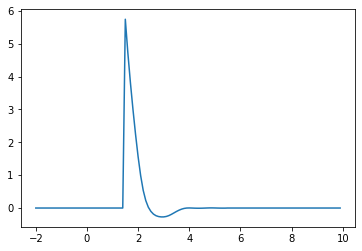

In [10]:
plt.plot(xpoints, uf2(xpoints))
plt.show()

## Einsum Tests

### 1-D

In [7]:
x = jnp.asarray([3.5,4.4])
c = coe
i, A = jax_spline(x)

reference = spline(x)
print(reference)


[-0.10517322 -0.00632792]


In [14]:
left = np.meshgrid(*[np.arange(degree+1) for degree in (3,)], indexing='ij')
right = i

id = jnp.add(left[0][None,...],
    right[(slice(0,2),) + (None,)*1])

In [15]:
c[id].shape

(2, 4)

In [16]:
jnp.einsum(c[id], [0,1], A, [0,1],[0])

DeviceArray([-0.10517322, -0.00632792], dtype=float64)

## Mapping test

In [22]:
x = jnp.arange(4.0*3).reshape((4,3))

In [28]:
x

DeviceArray([[ 0.,  1.,  2.],
             [ 3.,  4.,  5.],
             [ 6.,  7.,  8.],
             [ 9., 10., 11.]], dtype=float64)

In [25]:
f = lambda x: x + jnp.asarray([0,1,3])

In [26]:
from jax.lax import map

In [30]:
1

1